In [703]:
import pandas as pd
import os
import re
import numpy as np
import pymysql 
import sqlalchemy
from sqlalchemy.types import TIMESTAMP
import MySQLdb
import pyodbc
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data Preparing

In [616]:
def convert_location_col(df, filename):
    reg_pattern = '\"address\":\"([A-Za-z0-9\s./#\(\),-]+)\"'
    address_lst = list(map(lambda x: re.findall(pattern=reg_pattern, string=df['Location 1'][x].replace('&amp;', ' ')), range(len(df))))
    address_lst_flattened = []
    for i in range(len(address_lst)):
        try:
            address_lst_flattened.append(address_lst[i][0])
        except Exception as e:
            address_lst_flattened.append(np.nan)
    df['Location'] = address_lst_flattened
    df = df.drop(columns=['Location 1'])
    df.to_csv(filename)
    return df

In [617]:
file1 = 'oakland-crime-statistics-2011-to-2016/records-for-2012.csv'
file2 = 'oakland-crime-statistics-2011-to-2016/records-for-2014.csv'
df1 = convert_location_col(pd.read_csv(file1), file1)
df2 = convert_location_col(pd.read_csv(file2), file2)

### Load data into MySQL (Here use Sqlite)

In [689]:
class DataSqlLoader:
    def __init__(self, database):
        # connect to mysql local server
        self.database = database
        self.db = sqlite3.connect(self.database)
        self.c = self.db.cursor()
    
    def creat_tables(self):
        for year in range(1, 7):
            try:
                self.c.execute('''
                        CREATE TABLE IF NOT EXISTS crimedata_201{}
                            (
                              `Create Time`              TIME         NULL,
                              Location                   VARCHAR(100) NULL,
                              `Area Id`                  VARCHAR(5)   NULL,
                              Beat                       VARCHAR(10)  NULL,
                              Priority                   INT          NULL,
                              `Incident Type Id`         VARCHAR(10)  NULL,
                              `Incident Type Desciption` TEXT         NULL,
                              `Event Number`             VARCHAR(30)  NOT NULL
                                PRIMARY KEY,
                              `Closed Time`              TIME         NULL,
                              CONSTRAINT crimedata_2011_EventNumber_uindex
                              UNIQUE (`Event Number`)
                            );
                        '''.format(year))
            except Exception as e:
                print(e)
    
    def insert_into_tables_helper(self, df, table_name):
        engine = sqlalchemy.create_engine('sqlite:///{}'.format(self.database))
        df.to_sql(table_name, 
                  engine, 
                  if_exists='replace',
                  dtype={'Create Time': TIMESTAMP,
                         'Closed Time': TIMESTAMP})
        print('data insert DONE! :D')
        
            
    def insert_into_tables(self):
        columns = ['Create Time', 'Closed Time']
        for y in range(1,7):
            filename = 'oakland-crime-statistics-2011-to-2016/records-for-201{}.csv'.format(y)
            df = pd.read_csv(filename)
            try:
                df = df.drop(columns=['Unnamed: 0'])
            except Exception as e:
                print(e)
            for column in columns:
                tmp = []
                df = df.iloc[df[column].dropna().index, :].reset_index(drop=True)
                for i in df[column]:
                    ymy = i.split('T')[0]
                    hms = i.split('T')[1]
                    splited_lst = ymy.split('-')
                    year = splited_lst[0]
                    month = splited_lst[1][1:] if splited_lst[1].startswith('0') else splited_lst[1]
                    day = splited_lst[2][1:] if splited_lst[2].startswith('0')  else splited_lst[2]

                    splited_lst = hms.split(':')
                    hour = splited_lst[0][1:] if splited_lst[0].startswith('0') else splited_lst[0]
                    minute = splited_lst[1][1:] if splited_lst[1].startswith('0') else splited_lst[1]
                    second = splited_lst[2][1:] if splited_lst[2].startswith('0')  else splited_lst[2]

                    tmp.append(datetime(int(year), int(month), int(day), int(hour), int(minute), int(second)))

                df[column] = pd.DataFrame(tmp)
            df['Days to Resolve'] = pd.DataFrame(list(map(lambda x: x.days, df[columns[1]] - df[columns[0]])))
            df['Area Id'] = df['Area Id'].fillna(value=0)
            df['Priority'] = df['Priority'].dropna(axis=0)
            df['Incident Type Id'] = df['Incident Type Id'].dropna(axis=0)
            df['Event Number'] = df['Event Number'].dropna(axis=0)
            # print(df.tail())
            self.insert_into_tables_helper(df=df, table_name='crimedata_201{}'.format(y))
    
    
    def get_sample(self, table, limit=None):
        if limit == None:
            query = 'SELECT * FROM {};'.format(table)
        else:
            query = 'SELECT * FROM {} limit {};'.format(table, limit)
            pd.read_sql(sql=query, con=self.db)
        return pd.read_sql(sql=query, con=self.db)
    
    def sql_query(self, query):
        try:
            return pd.read_sql(sql=query, con=self.db)
        except Exception as e:
            print(e)
            
    def close(self):
        self.db.close()

In [691]:
dsl = DataSqlLoader('oaklandcrime.db')
# dsl.creat_tables()
dsl.insert_into_tables()

"['Unnamed: 0'] not found in axis"
data insert DONE! :D
data insert DONE! :D
"['Unnamed: 0'] not found in axis"
data insert DONE! :D
data insert DONE! :D
"['Unnamed: 0'] not found in axis"
data insert DONE! :D
"['Unnamed: 0'] not found in axis"
data insert DONE! :D


### Exploratory analysis

####  Crime Rate in Different Areas

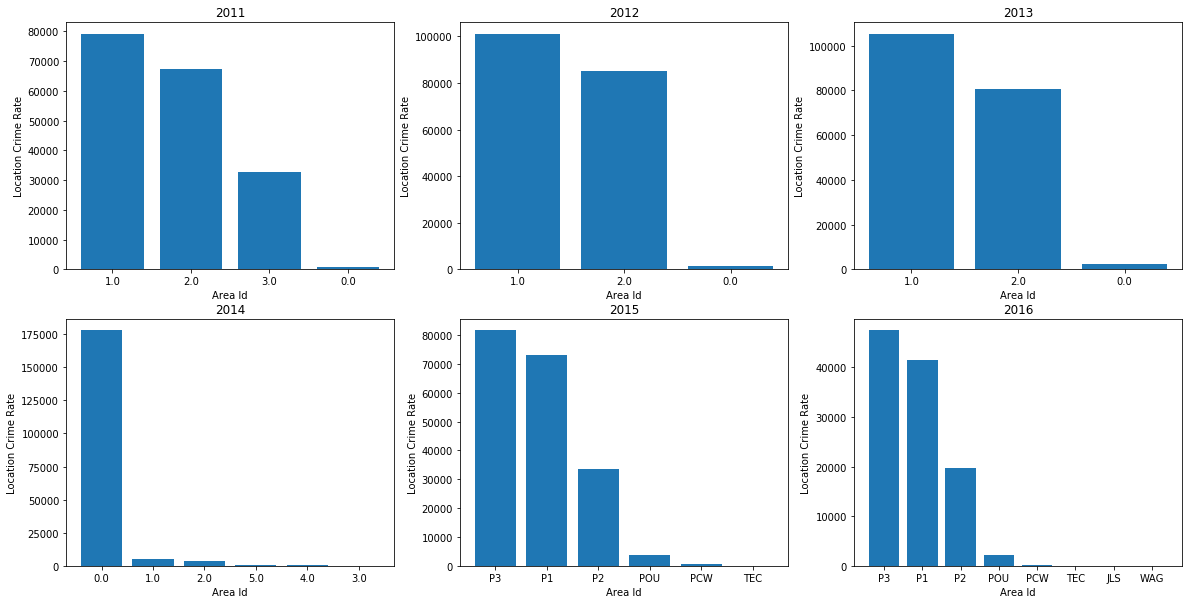

In [730]:
plt.figure(figsize=(20, 10))
for year in range(1, 7):
    query = '''
        SELECT "Area Id",
          count(*) as locationcrimerate
        FROM crimedata_201{}
        GROUP BY "Area Id"
        ORDER BY locationcrimerate DESC ;
        '''.format(year)
    df_tmp = dsl.sql_query(query)
    plt.subplot(2, 3, year)
    plt.bar(x=df_tmp['Area Id'].astype('str').values, height=df_tmp['locationcrimerate'].values)
    plt.xlabel(xlabel='Area Id')
    plt.ylabel(ylabel='Location Crime Rate')
    plt.title('201{}'.format(year))
plt.show()

#### Different incident solving time

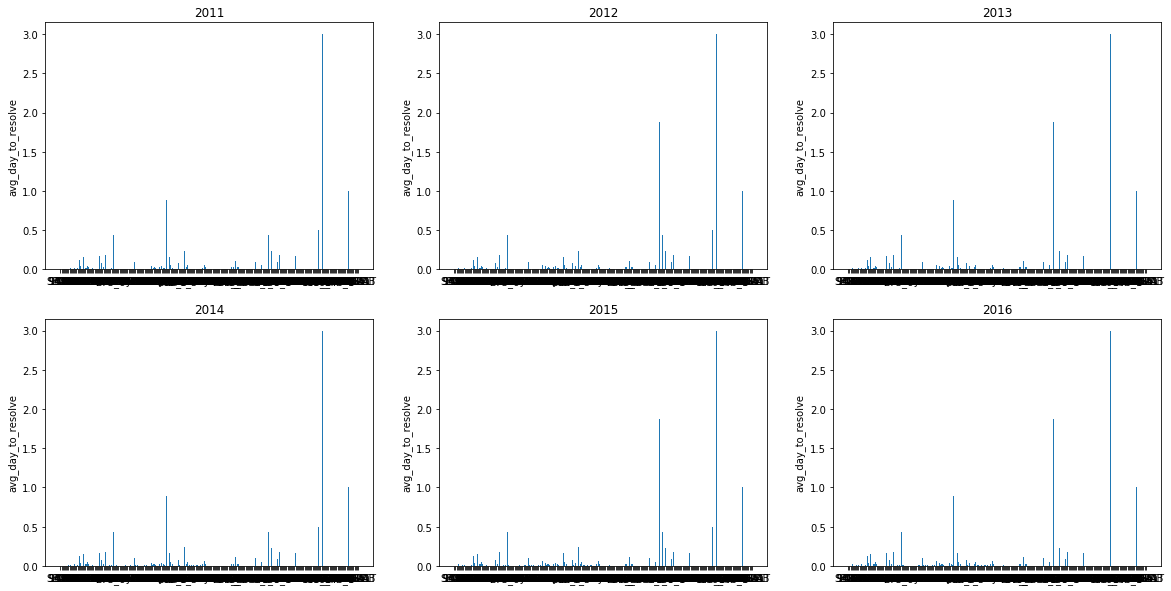

In [733]:
plt.figure(figsize=(20, 10))
for year in range(1, 7):
    query = '''
    SELECT Priority, "Incident Type Id", "Incident Type Description",
      count(*) as number_of_occurrence,
      avg("Days to Resolve") as avg_day_to_resolve
    FROM crimedata_201{}
    GROUP BY "Incident Type Id"
    ORDER BY count(*) DESC ;
    '''.format(year)
    df_tmp = dsl.sql_query(query)
    plt.subplot(2, 3, year)
    plt.bar(x=df_tmp['Incident Type Id'].astype('str').values, height=df_tmp['avg_day_to_resolve'].values)
    #plt.xticks(rotation=90)
    #plt.xlabel(xlabel='Incident Type Id')
    plt.ylabel(ylabel='avg_day_to_resolve')
    plt.title('201{}'.format(year))
plt.show()

#### What crime takes longest time to solve each year?

The top 3 crime that took the longest time to resolve in year 2011:
[['262' 'SPOUSAL RAPE' 3.0]
 ['187' 'MURDER' 1.875]
 ['666' 'PETTY THEFT W/PRIORS' 1.0]]


The top 3 crime that took the longest time to resolve in year 2012:
[['20001' 'HIT & RUN RESULTING' 0.7746478873239436]
 ['187' 'MURDER' 0.7142857142857143]
 ['484G' 'FRAUDULENT USE OF AC' 0.4]]


The top 3 crime that took the longest time to resolve in year 2013:
[['187' 'MURDER' 32.57575757575758]
 ['207' 'KIDNAPPING' 4.948275862068965]
 ['148' 'OBSTRUCTING JUSTICE-' 2.375]]


The top 3 crime that took the longest time to resolve in year 2014:
[['187' 'MURDER' 5.46875]
 ['20001' 'HIT & RUN RESULTING' 1.2639821029082774]
 ['215' 'CARJACKING' 0.8735294117647059]]


The top 3 crime that took the longest time to resolve in year 2015:
[['187' 'MURDER' 18.483870967741936]
 ['945A' 'AMBULANCE REQUESTED' 12.4]
 ['EVID' 'EVIDENCE' 5.484848484848484]]


The top 3 crime that took the longest time to resolve in year 2016:
[['187' 'MURDER' 

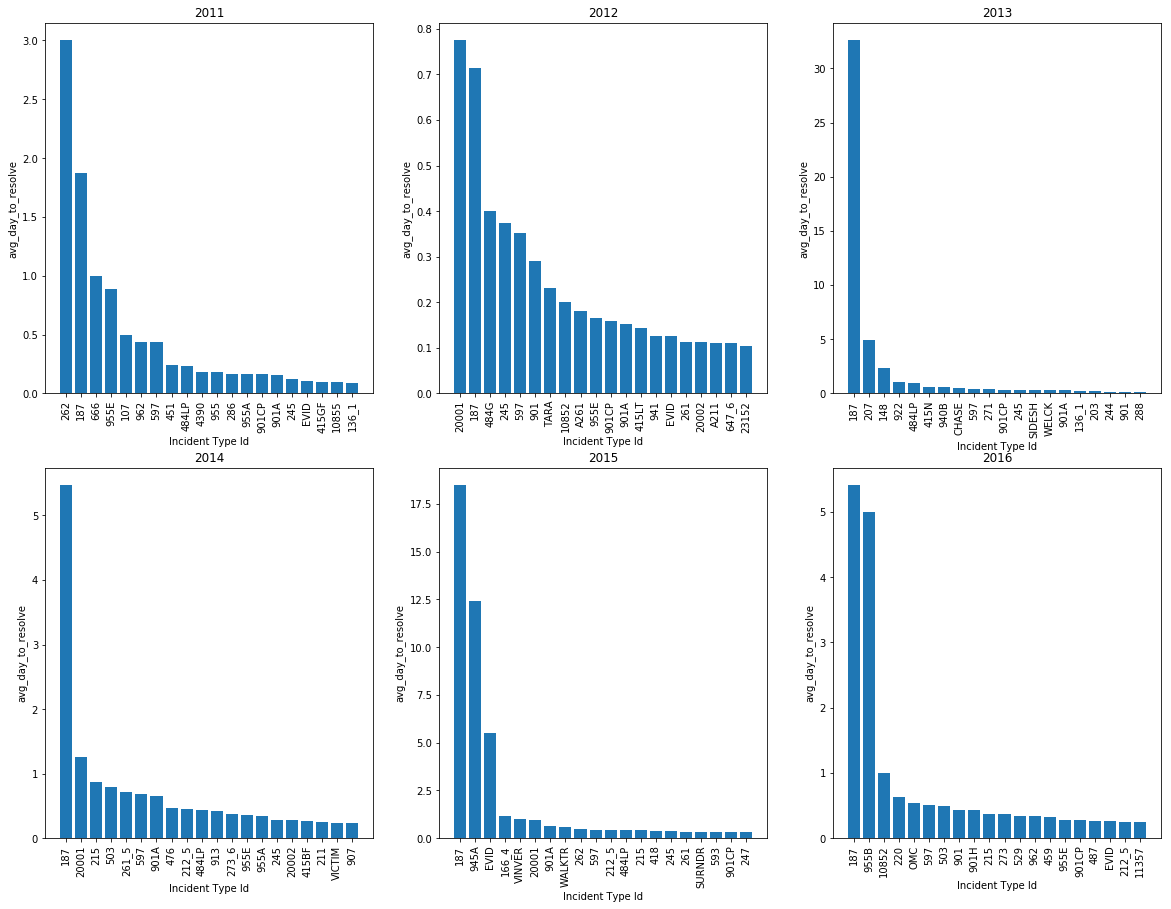

In [750]:
plt.figure(figsize=(20, 15))
for year in range(1,7):
    query = '''
        SELECT "Incident Type Id",
          "Incident Type Description",
          avg_day_to_resolve FROM (SELECT Priority, "Incident Type Id", "Incident Type Description",
          count(*) as number_of_occurrence,
          avg("Days to Resolve") as avg_day_to_resolve
        FROM crimedata_201{}
        GROUP BY "Incident Type Id"
        ORDER BY count(*) DESC)
        ORDER BY avg_day_to_resolve DESC LIMIT 20;
    '''.format(year)
    df_tmp = dsl.sql_query(query)
    print('The top 3 crime that took the longest time to resolve in year 201{}:'.format(year))
    print(df_tmp.iloc[:3, :].values)
    print('\n')
    
    plt.subplot(2, 3, year)
    plt.bar(x=df_tmp['Incident Type Id'].astype('str').values, height=df_tmp['avg_day_to_resolve'].values)
    plt.xticks(rotation=90)
    plt.xlabel(xlabel='Incident Type Id')
    plt.ylabel(ylabel='avg_day_to_resolve')
    plt.title('201{}'.format(year))
plt.show()

#### 

### Model Building

In [669]:
class Model(object):
    def __init__(self, X=None, y=None):
        self.seed = SEED
        self.split_ratio = SPLIT_RATIO
        self.model = None
        self.X = X
        self.y = y

    def simple_split(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                            self.y,
                                                            test_size=self.split_ratio,
                                                            random_state=self.seed)
        return X_train, X_test, y_train, y_test

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def loss(self, X_train, X_test, y_train, y_test):
        return NotImplemented

    def cross_val_evaluate(self, fold=None, cross_val=False):
        return NotImplemented
    

class LinearRegressionModel(Model):
    def __init__(self):
        super(LinearRegressionModel, self).__init__(X=absent_df.iloc[:, :-1],
                                                    y=absent_df.iloc[:, -1])
        self.model = LinearRegression(fit_intercept=True, normalize=True)

    def fit(self, X_train, y_train):
        super(LinearRegressionModel, self).fit(X_train, y_train)

    def predict(self, X_test):
        return super(LinearRegressionModel, self).predict(X_test)

    def loss(self, X_train, X_test, y_train, y_test):
        self.fit(X_train, y_train)
        y_pred = self.predict(X_test)
        return np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))

    def cross_val_evaluate(self, fold=None, cross_val=False):
        if not cross_val:
            X_train, X_test, y_train, y_test = self.simple_split()
            return self.loss(X_train, X_test, y_train, y_test)
        else:
            rmse_lst = []
            skf = StratifiedKFold(n_splits=fold, random_state=self.seed, shuffle=True)
            for train_index, test_index in skf.split(self.X, self.y):
                X_train, X_test, y_train, y_test = self.X.iloc[train_index, :], self.X.iloc[test_index, :], self.y[train_index], self.y[test_index]
                rmse = self.loss(X_train, X_test, y_train, y_test)
                rmse_lst.append(rmse)
            return rmse_lst, np.mean(rmse_lst)
        
class KNNClassifier(Model):
    def __init__(self):
        super(KNNClassifier, self).__init__(X=load_breast_cancer().data,
                                            y=load_breast_cancer().target)
        self.model = KNeighborsClassifier(n_neighbors=5)

    def fit(self, X_train, y_train):
        return super(KNNClassifier, self).fit(X_train, y_train)

    def predict(self, X_test):
        return super(KNNClassifier, self).predict(X_test)

    def loss(self, X_train, X_test, y_train, y_test):
        self.fit(X_train, y_train)
        y_pred = self.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
        auc_value = auc(fpr, tpr)
        return fpr, tpr, auc_value

    def plot_roc(self, fpr, tpr, auc_value, fold=None):
        plt.figure()
        plt.plot(fpr, tpr, color='red',
                 lw=2, label='ROC curve (area = %0.3f)' % auc_value)
        plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        if fold != None:
            plt.title('ROC plot of fold {}, auc = {}'.format(fold, auc_value))
        else:
            plt.title('ROC plot, auc = {}'.format(auc_value))
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def cross_val_evaluate(self, fold=None, cross_val=False):
        if not cross_val:
            X_train, X_test, y_train, y_test = self.simple_split()
            _, _, auc_value = self.loss(X_train, X_test, y_train, y_test)
            return auc_value
        else:
            auc_lst = []
            skf = StratifiedKFold(n_splits=fold, random_state=self.seed, shuffle=True)
            fold = 1
            for train_index, test_index in skf.split(self.X, self.y):
                X_train, X_test, y_train, y_test = self.X[train_index, :], self.X[test_index, :], self.y[train_index], self.y[test_index]
                fpr, tpr, auc_value = self.loss(X_train, X_test, y_train, y_test)
                self.plot_roc(fpr, tpr, auc_value, fold=fold)
                auc_lst.append(auc_value)
                fold += 1
            return auc_lst, np.mean(auc_lst)

class KNNRegressionModel(Model):
    def __init__(self,
                 dist='minkowski',
                 weights='distance',
                 max_k=10,
                 max_p=10):
        super(KNNRegressionModel, self).__init__(X=absent_df.iloc[:, :-1],
                                                 y=absent_df.iloc[:, -1])
        self.dist = dist
        self.weights = weights
        self.max_k = max_k
        self.max_p = max_p
        self.model = None

    def knn_regression_model(self, k, p):
        return KNeighborsRegressor(n_neighbors=k,
                                   weights=self.weights,
                                   metric=self.dist,
                                   p=p)

    def fit(self, X_train, y_train):
        return super(KNNRegressionModel, self).fit(X_train, y_train)

    def predict(self, X_test):
        return super(KNNRegressionModel, self).predict(X_test)

    def loss(self, X_train, X_test, y_train, y_test):
        self.fit(X_train, y_train)
        y_pred = self.predict(X_test)
        return np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))

    def cross_val_evaluate(self, fold=10, cross_val=True):
        fold_lst = []
        k_lst = []
        p_lst = []
        rmse_lst = []
        skf = StratifiedKFold(n_splits=fold, random_state=self.seed, shuffle=True)
        fold = 1
        for train_index, test_index in skf.split(self.X, self.y):
            X_train, X_test, y_train, y_test = self.X.iloc[train_index, :], self.X.iloc[test_index, :], self.y[train_index], self.y[test_index]
            for k in range(1, self.max_k + 1):
                for p in range(1, self.max_p + 1):
                    self.model = self.knn_regression_model(k, p)
                    rmse = self.loss(X_train, X_test, y_train, y_test)
                    fold_lst.append(fold)
                    k_lst.append(k)
                    p_lst.append(p)
                    rmse_lst.append(rmse)
            fold += 1
        df = pd.DataFrame({
            'fold': fold_lst,
            'k': k_lst,
            'p': p_lst,
            'rmse': rmse_lst
        })

        min_rmse_indexes = df.groupby(by=df['fold']).apply(lambda x: x.rmse.values.argmin())
        min_rmse_df = pd.DataFrame(
            df[df.fold == fold].iloc[min_rmse_indexes[fold], :] for fold in range(1, len(min_rmse_indexes) + 1))
        return df, min_rmse_df
    

### test

,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
180015,NaN,NaN,,0.0,NaN,NaN,NaN,NaN,NaN,NaN
